In [1]:
import pandas as pd
import csv

import sys
sys.path.insert(0, '../')

import seaborn as sns
import matplotlib.pyplot as plt

import collections
from collections import defaultdict

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [8]:
df = pd.read_csv("/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/SICK/SICK.txt", sep='\t')


In [23]:
df

,pair_ID,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA,sentence_A_dataset,sentence_B_dataset,SemEval_set,sentA_length,sentB_length
0,1,A group of kids is playing in a yard and an old man is standing in the background,A group of boys in a yard is playing and a man is standing in the background,NEUTRAL,4.5,A_neutral_B,B_neutral_A,FLICKR,FLICKR,TRAIN,81,76
1,2,A group of children is playing in the house and there is no man standing in the background,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,3.2,A_contradicts_B,B_neutral_A,FLICKR,FLICKR,TRAIN,90,81
2,3,The young boys are playing outdoors and the man is smiling nearby,The kids are playing outdoors near a man with a smile,ENTAILMENT,4.7,A_entails_B,B_entails_A,FLICKR,FLICKR,TRAIN,65,53
3,4,The young boys are playing outdoors and the man is smiling nearby,There is no boy playing outdoors and there is no man smiling,CONTRADICTION,3.6,A_contradicts_B,B_contradicts_A,FLICKR,FLICKR,TRIAL,65,60
4,5,The kids are playing outdoors near a man with a smile,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,3.4,A_neutral_B,B_neutral_A,FLICKR,FLICKR,TRAIN,53,81
...,...,...,...,...,...,...,...,...,...,...,...,...
9835,9996,A man is in a parking lot and is playing tennis against a large wall,The snowboarder is leaping fearlessly over white snow,NEUTRAL,1.0,A_neutral_B,B_neutral_A,FLICKR,FLICKR,TEST,68,53
9836,9997,Someone is boiling okra in a pot,The man is not playing the drums,NEUTRAL,1.0,A_neutral_B,B_neutral_A,SEMEVAL,SEMEVAL,TRAIN,32,32
9837,9998,The man is singing heartily and playing the guitar,A bicyclist is holding a bike over his head in a group of people,NEUTRAL,1.0,A_neutral_B,B_neutral_A,SEMEVAL,FLICKR,TRAIN,50,64
9838,9999,A man in blue has a yellow ball in the mitt,A man is jumping rope outside,NEUTRAL,1.2,A_neutral_B,B_neutral_A,SEMEVAL,FLICKR,TRAIN,43,29


In [13]:
pd.options.display.max_colwidth=200

In [16]:
df["sentA_length"]= df["sentence_A"].str.len()
df["sentB_length"]= df["sentence_B"].str.len()

In [20]:
df=df.drop('sentence_B_original', axis=1)

### Grouping, size and shapes

In [28]:
df.shape

(9840, 12)

In [22]:
df.groupby('entailment_label').size().sort_values(ascending=False)

entailment_label
NEUTRAL          5595
ENTAILMENT       2821
CONTRADICTION    1424
dtype: int64

In [24]:
df.groupby('sentence_A_dataset').size().sort_values(ascending=False)

sentence_A_dataset
FLICKR     4979
SEMEVAL    4861
dtype: int64

In [25]:
df.groupby('sentence_B_dataset').size().sort_values(ascending=False)

sentence_B_dataset
FLICKR     5052
SEMEVAL    4788
dtype: int64

In [26]:
df.groupby('SemEval_set').size().sort_values(ascending=False)

SemEval_set
TEST     4906
TRAIN    4439
TRIAL     495
dtype: int64

In [29]:
df.groupby('entailment_label')['sentA_length'].mean().sort_values(ascending=False)

entailment_label
ENTAILMENT       47.674229
NEUTRAL          47.016801
CONTRADICTION    43.728933
Name: sentA_length, dtype: float64

In [30]:
df.groupby('sentence_A_dataset')['sentA_length'].mean().sort_values(ascending=False)

sentence_A_dataset
FLICKR     57.059851
SEMEVAL    36.148323
Name: sentA_length, dtype: float64

In [31]:
df.groupby('SemEval_set')['sentA_length'].mean().sort_values(ascending=False)

SemEval_set
TRIAL    48.240404
TRAIN    46.760757
TEST     46.548716
Name: sentA_length, dtype: float64

### Plot length of sentences

In [38]:
def hist_length(df):
    
    plt.figure(figsize=(10,8))
    sns.histplot(data=df, x='sentA_length', hue='entailment_label')
    plt.figure(figsize=(10,8))
    sns.histplot(data=df, x='sentB_length', hue='entailment_label')
    plt.figure(figsize=(10,8))
    sns.histplot(data=df, x='sentA_length', hue='SemEval_set')
    plt.figure(figsize=(10,8))
    sns.histplot(data=df, x='sentB_length', hue='SemEval_set')
    
    print('\n Average lenght of sentences_A :', df["sentA_length"].mean(), '\n' )
    print('Average length of sentences_A per entailment_label: \n',  df.groupby('entailment_label')['sentA_length'].mean().sort_values(ascending=False), '\n')
    print('Average length of sentences_A per SemEval_set: \n',  df.groupby('SemEval_set')['sentA_length'].mean().sort_values(ascending=False), '\n')
    print('Average length of sentences_A per sentence_A_dataset: \n',  df.groupby('sentence_A_dataset')['sentA_length'].mean().sort_values(ascending=False), '\n')
    
    print('\n Average lenght of sentences_B :', df["sentB_length"].mean(), '\n')
    print('Average length of sentences_B per entailment_label: \n',  df.groupby('entailment_label')['sentB_length'].mean().sort_values(ascending=False), '\n')
    print('Average length of sentences_B per SemEval_set: \n',  df.groupby('SemEval_set')['sentB_length'].mean().sort_values(ascending=False), '\n')
    print('Average length of sentences_B per sentence_B_dataset: \n',  df.groupby('sentence_B_dataset')['sentB_length'].mean().sort_values(ascending=False), '\n')
    


 Average lenght of sentences_A : 46.729471544715445 

Average length of sentences_A per entailment_label: 
 entailment_label
ENTAILMENT       47.674229
NEUTRAL          47.016801
CONTRADICTION    43.728933
Name: sentA_length, dtype: float64 

Average length of sentences_A per SemEval_set: 
 SemEval_set
TRIAL    48.240404
TRAIN    46.760757
TEST     46.548716
Name: sentA_length, dtype: float64 

Average length of sentences_A per sentence_A_dataset: 
 sentence_A_dataset
FLICKR     57.059851
SEMEVAL    36.148323
Name: sentA_length, dtype: float64 


 Average lenght of sentences_B : 45.75782520325203 

Average length of sentences_B per entailment_label: 
 entailment_label
NEUTRAL          47.368543
CONTRADICTION    44.144663
ENTAILMENT       43.377526
Name: sentB_length, dtype: float64 

Average length of sentences_B per SemEval_set: 
 SemEval_set
TRIAL    45.898990
TEST     45.819405
TRAIN    45.674026
Name: sentB_length, dtype: float64 

Average length of sentences_B per sentence_B_data

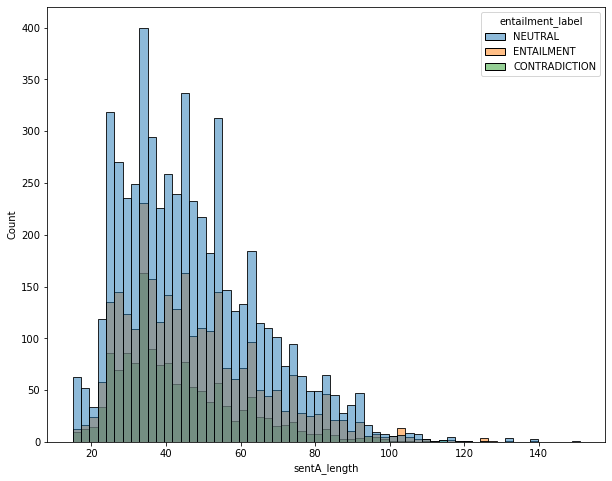

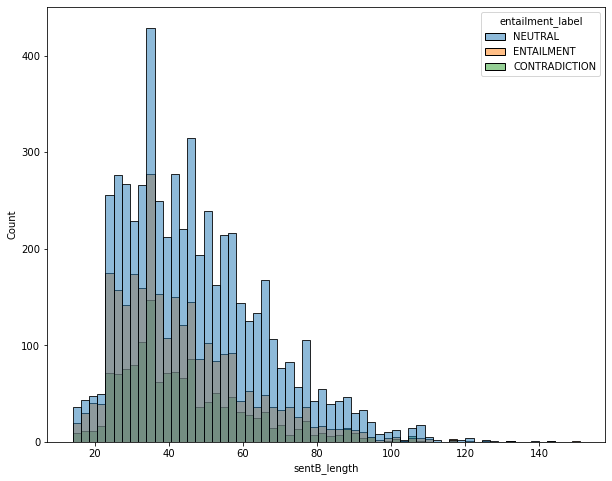

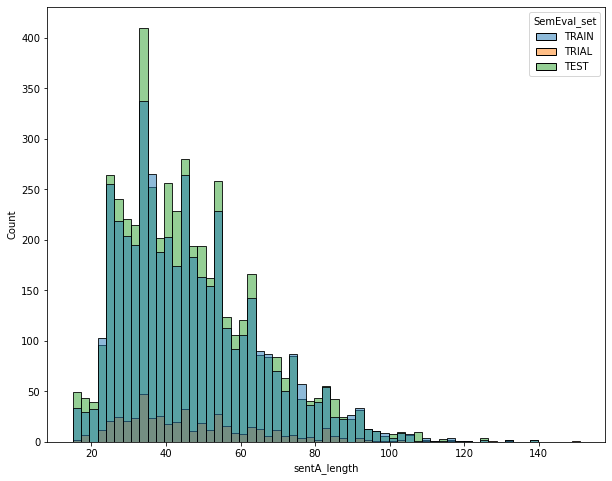

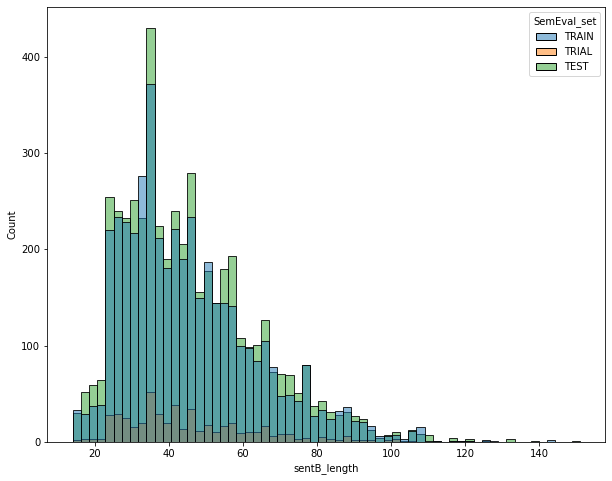

In [39]:
hist_length(df)

### Analyzing word type

In [40]:
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariabrullmartinez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
def stop_words_normal_words(df, sentence):
    corpus=[]

    sentences= df[sentence].str.split()
    words=sentences.values.tolist()
    corpus=[word for i in words for word in i]

    dict_stop_word_count=defaultdict(int)
    for word in corpus:
        if word in stop_words:
            dict_stop_word_count[word]+=1 
            
    stop_words_list=list(dict_stop_word_count.keys())
    count_stop_words_list=list(dict_stop_word_count.values())
    
    plt.figure(figsize=(25,20))         
    sns.barplot( count_stop_words_list, stop_words_list).set_title('Stop words frequency')
    
    print('The total length of our vocab is:', len(stop_words_list))
    
    ##stop_words
    counter=collections.Counter(corpus)
    most_common_words=counter.most_common()
    
    word_list=[]
    count_word_list = []
    
    for word,count in most_common_words[:150]:
        if (word not in stop_words):
            word_list.append(word)
            count_word_list.append(count)
        
    plt.figure(figsize=(20,18))        
    sns.barplot( count_word_list, word_list).set_title('Words frequency')
    
    print('The total sum of stop words is:', len(word_list))

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


The total length of our vocab is: 73
The total sum of stop words is: 114


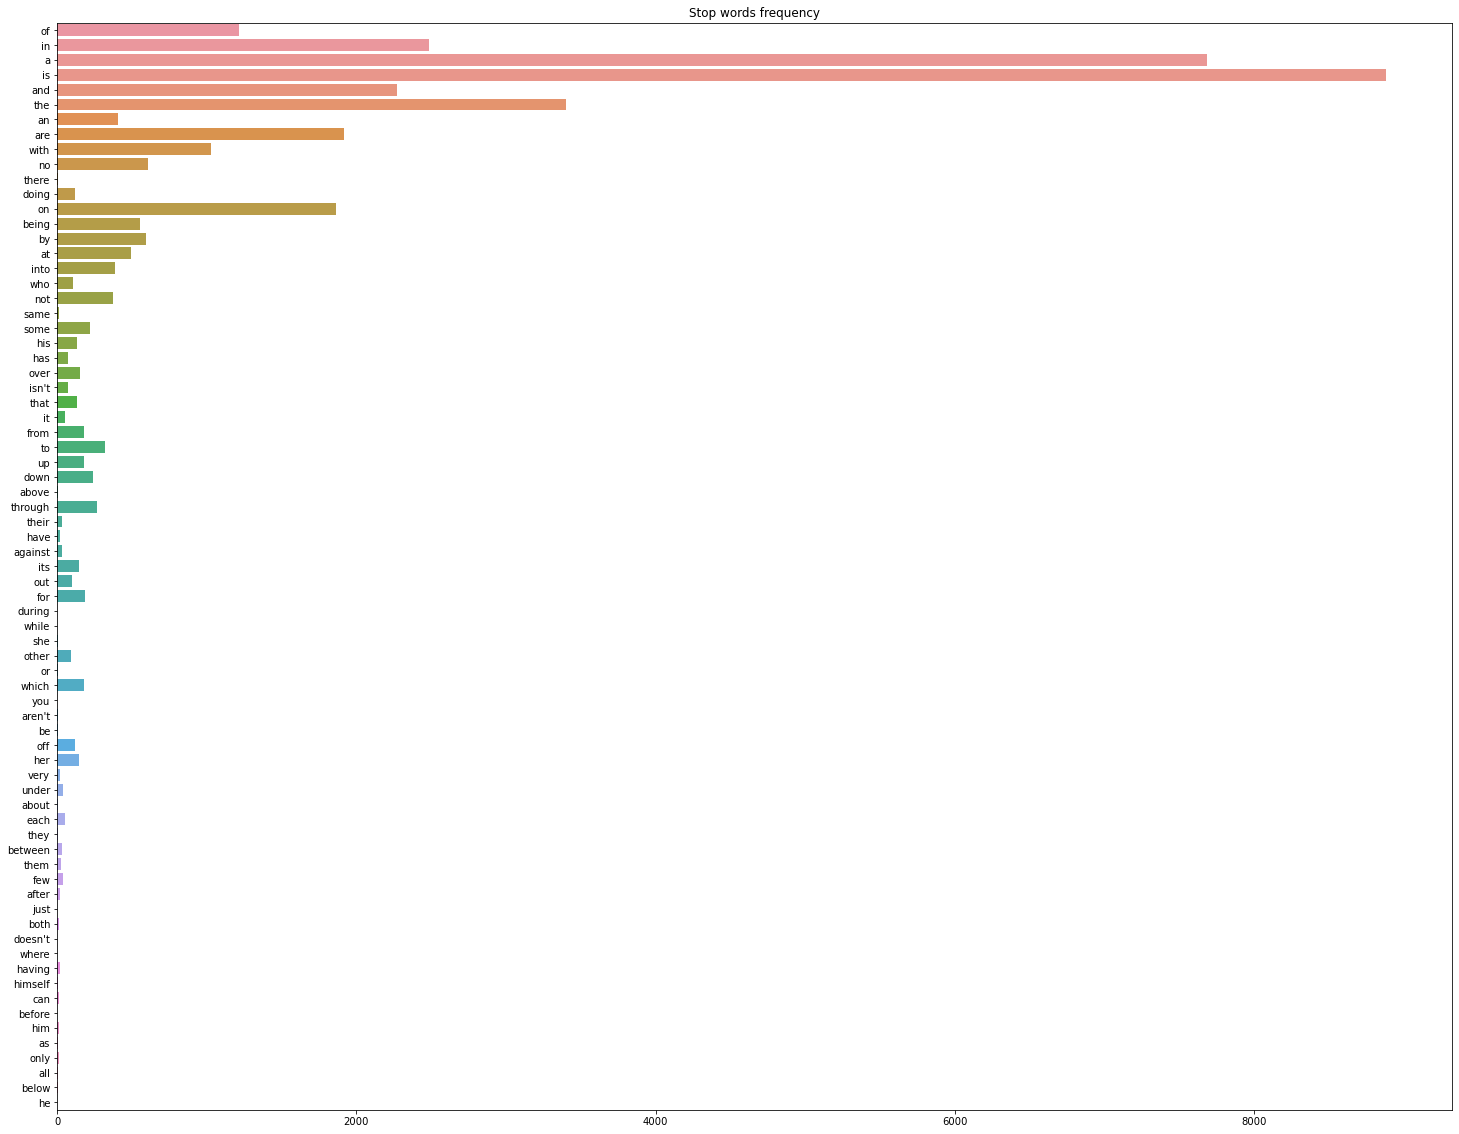

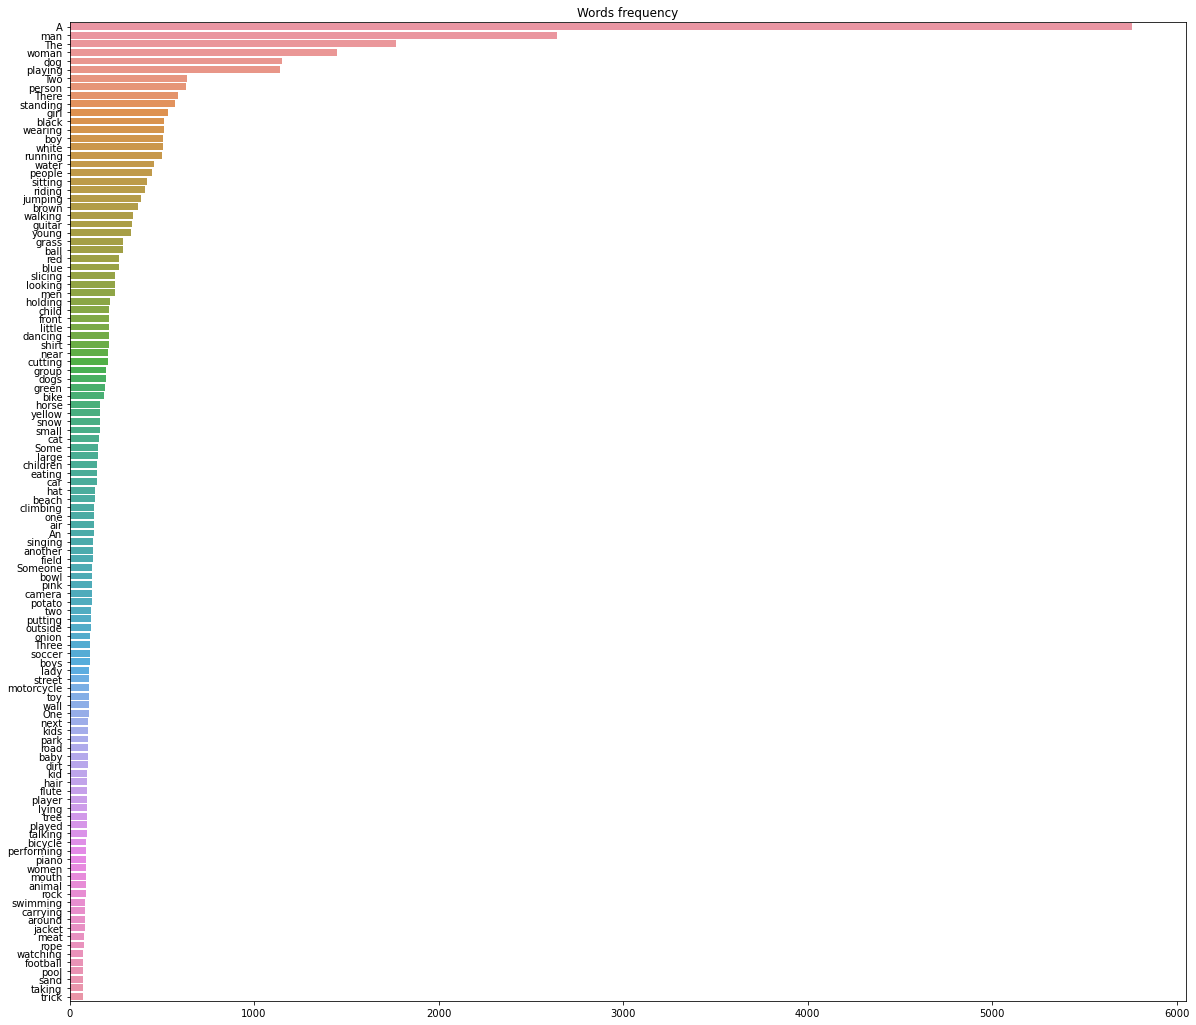

In [43]:
stop_words_normal_words(df, 'sentence_B')

### N-gram analysis

In [44]:
def get_top_pair_words(data, n):
    vec = CountVectorizer(ngram_range=(n, n)).fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    plt.figure(figsize=(20,18))  
    word,count=map(list,zip(*words_freq[0:20]))
    g=sns.barplot(count, word).set_title('Two pair words frequency')
   


/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


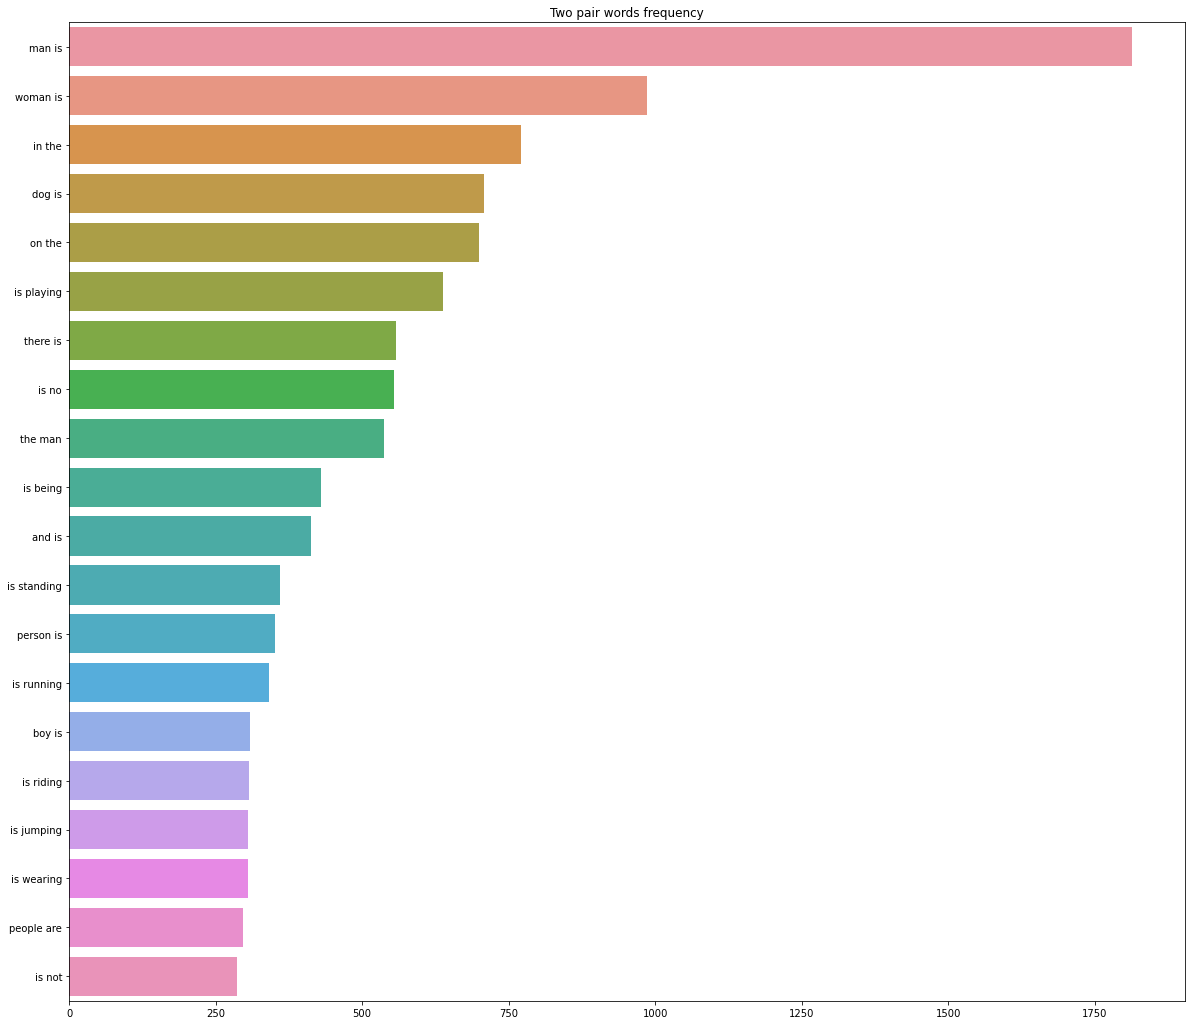

In [45]:
get_top_pair_words(df['sentence_A'], 2)



### Word cloud

In [46]:
def get_word_cloud(data):
    stop_words = nltk.corpus.stopwords.words("english")
    
    word_cloud = WordCloud(
        background_color='black',
        stopwords=stop_words,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    word_cloud=word_cloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(word_cloud)
    plt.show()



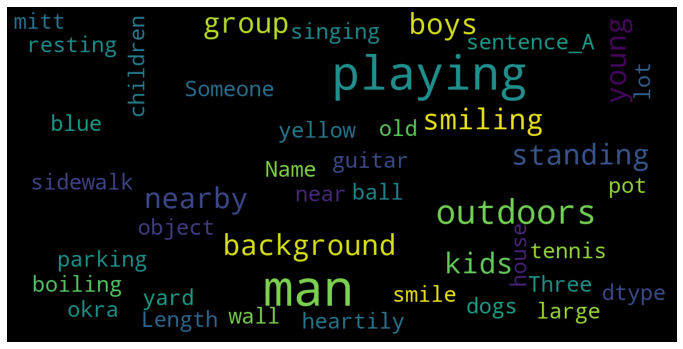

In [48]:
get_word_cloud(df['sentence_A'])

### LDA topic classification

In [49]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mariabrullmartinez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mariabrullmartinez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [61]:
def get_lda_topics(df, sentence):
    text=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    
    for sentence in df[sentence]:
        words=[w for w in word_tokenize(sentence) if (w not in stop_words)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        text.append(words)
        
    dict_text_gensim=gensim.corpora.Dictionary(text)
    bow_corpus = [dict_text_gensim.doc2bow(list_words) for list_words in text]
    
    lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 9, 
                                   id2word = dict_text_gensim,
                                   workers = 2)
    lda_model.show_topics()   
    
    return lda_model.show_topics(), lda_model,bow_corpus, dict_text_gensim

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
param= get_lda_topics(df, 'sentence_A')

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(<gensim.models.ldamulticore.LdaMulticore at 0x7ffd7f422880>,
 [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
  [(0, 1), (1, 1), (3, 1), (5, 1), (6, 1), (8, 1), (9, 1)],
  [(3, 1), (5, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)],
  [(3, 1), (5, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)],
  [(2, 1), (3, 1), (5, 1), (10, 1), (13, 1), (16, 1), (17, 1)],
  [(3, 1), (5, 1), (11, 1), (13, 1), (14, 1), (18, 1)],
  [(0, 1), (1, 1), (3, 1), (5, 1), (6, 1), (7, 1), (11, 1)],
  [(0, 1), (1, 1), (3, 1), (5, 1), (6, 1), (8, 1), (9, 1)],
  [(3, 1), (5, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)],
  [(3, 1),
   (19, 1),
   (20, 1),
   (21, 1),
   (22, 1),
   (23, 1),
   (24, 1),
   (25, 1),
   (26, 1)],
  [(3, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)],
  [(23, 1), (27, 1), (28, 1)],
  [(23, 1), (27, 1), (29, 1), (30, 1)],
  [(3, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)],
  [(3, 1), (19, 1)

In [57]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [58]:
lda_model=param[1]
bow_corpus=param[2]
dict_text_gensim=


vis = gensimvis.prepare(lda_model, bow_corpus, dict_text_gensim)
vis

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'lda_model' is not defined